In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

# **CARGAR DATASET**

In [2]:
from google.colab import files
files.upload()

df = pd.read_csv("UCI_Credit_Card.csv")

# Ver primeras filas
print(df.shape)
df.head()

Saving UCI_Credit_Card.csv to UCI_Credit_Card.csv
(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Vamos a renombrar la columna 'default.payment.next.month' por 'default_payment' para que sea más legible

In [3]:
df.rename(columns={
    'default.payment.next.month': 'default_payment'
}, inplace=True)

# **EXPLORACIÓN DE DATOS**

In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               30000 non-null  int64  
 1   LIMIT_BAL        30000 non-null  float64
 2   SEX              30000 non-null  int64  
 3   EDUCATION        30000 non-null  int64  
 4   MARRIAGE         30000 non-null  int64  
 5   AGE              30000 non-null  int64  
 6   PAY_0            30000 non-null  int64  
 7   PAY_2            30000 non-null  int64  
 8   PAY_3            30000 non-null  int64  
 9   PAY_4            30000 non-null  int64  
 10  PAY_5            30000 non-null  int64  
 11  PAY_6            30000 non-null  int64  
 12  BILL_AMT1        30000 non-null  float64
 13  BILL_AMT2        30000 non-null  float64
 14  BILL_AMT3        30000 non-null  float64
 15  BILL_AMT4        30000 non-null  float64
 16  BILL_AMT5        30000 non-null  float64
 17  BILL_AMT6   

Vamos a ver la proporción de impagos:

In [5]:
print("Proporción de impagos:")
print(df['default_payment'].value_counts(normalize=True))

Proporción de impagos:
default_payment
0    0.7788
1    0.2212
Name: proportion, dtype: float64


# **LIMPIEZA DE DATOS**


Primero vamos a ver los valores únicos en las variables categóricas (SEX, EDUCATION, MARRIAGE)

In [6]:
for col in ['SEX', 'EDUCATION', 'MARRIAGE']:
    print(col, df[col].unique())

SEX [2 1]
EDUCATION [2 1 3 5 4 6 0]
MARRIAGE [1 2 3 0]


Se reemplazan los valores atípicos de EDUCATION (0, 5, 6 → 4 “otros”) y MARRIAGE (0 → 3 “otros”) para que solo queden categorías válidas.


In [7]:
df['EDUCATION'] = df['EDUCATION'].replace({0:4, 5:4, 6:4})
df['MARRIAGE'] = df['MARRIAGE'].replace({0:3})

comprobamos los cambios:

In [8]:
for col in ['SEX', 'EDUCATION', 'MARRIAGE']:
    print(col, df[col].unique())

SEX [2 1]
EDUCATION [2 1 3 4]
MARRIAGE [1 2 3]


A continuación vamos a comprobar si existen valores nulos, para tratarlos en casi que encontremos.

In [9]:
print(df.isnull().sum())

ID                 0
LIMIT_BAL          0
SEX                0
EDUCATION          0
MARRIAGE           0
AGE                0
PAY_0              0
PAY_2              0
PAY_3              0
PAY_4              0
PAY_5              0
PAY_6              0
BILL_AMT1          0
BILL_AMT2          0
BILL_AMT3          0
BILL_AMT4          0
BILL_AMT5          0
BILL_AMT6          0
PAY_AMT1           0
PAY_AMT2           0
PAY_AMT3           0
PAY_AMT4           0
PAY_AMT5           0
PAY_AMT6           0
default_payment    0
dtype: int64


Al revisar los valores nulos en el dataset vemos que no existen valores nulos en ninguna de las variables, por lo que no es necesario aplicar técnicas de imputación.


Vamos a eliminar variables que son poco relevantes, por ejemplo, la variable ID no aporta nada.

In [10]:
df = df.drop(columns=['ID'])

# **ANÁLISIS INDIVIDUAL DE VARIABLES**
**Histograma de edad**

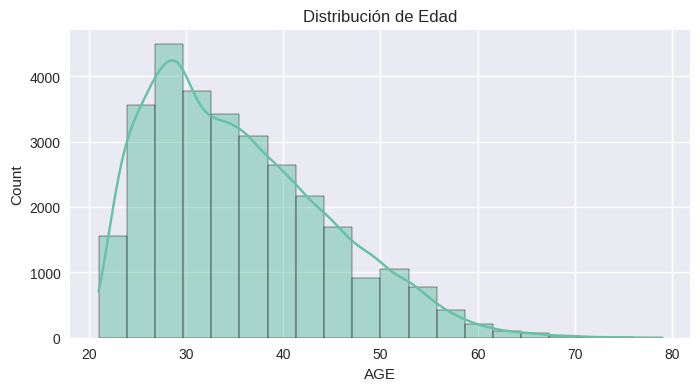

In [11]:
plt.figure(figsize=(8,4))
sns.histplot(df['AGE'], bins=20, kde=True)
plt.title("Distribución de Edad")
plt.show()

La mayoría de los clientes son adultos jóvenes y de mediana edad, lo que puede ser relevante para segmentación o análisis de riesgo.

**Porcentaje de impagos por género**

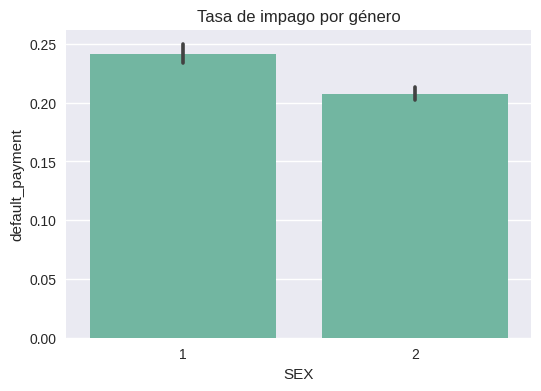

In [12]:
plt.figure(figsize=(6,4))
sns.barplot(x='SEX', y='default_payment', data=df)
plt.title("Tasa de impago por género")
plt.show()

Los hombres tienen más tendencia a entrar en impago que las mujeres.

**Porcentaje de impagos por edad**

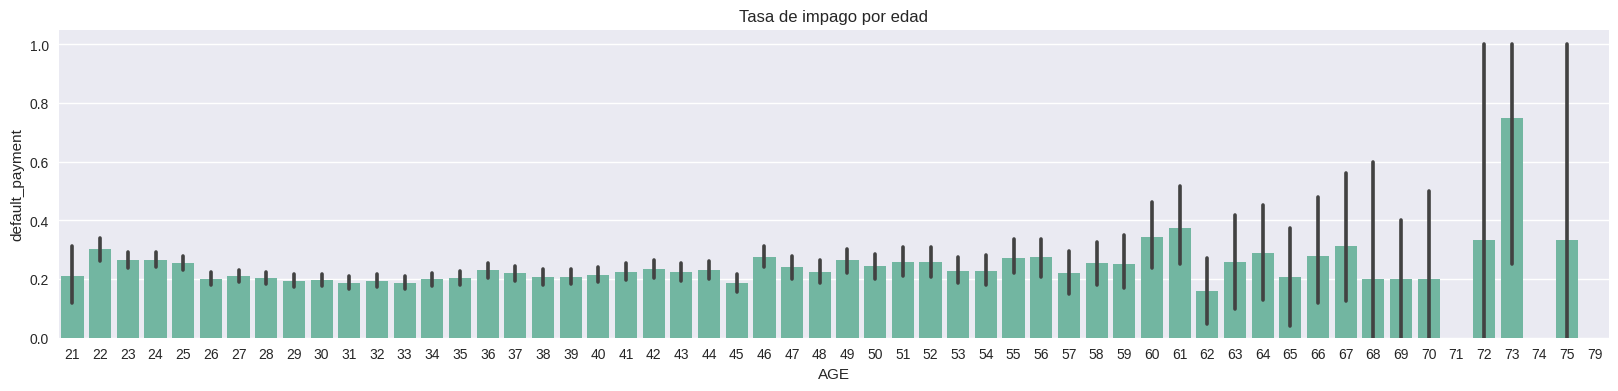

In [13]:
plt.figure(figsize=(20,4))
sns.barplot(x='AGE', y='default_payment', data=df)
plt.title("Tasa de impago por edad")
plt.show()

Clientes muy jóvenes (21–24 años) y mayores de 60 años muestran una mayor variabilidad y algunas tasas de impago más altas. Las edades más avanzadas (70–79) muestran tasas de impago más elevadas, aunque la muestra es más pequeña.

# **CORRELACIÓN**

Vamos a ver la relación lineal entre las variables numéricas.

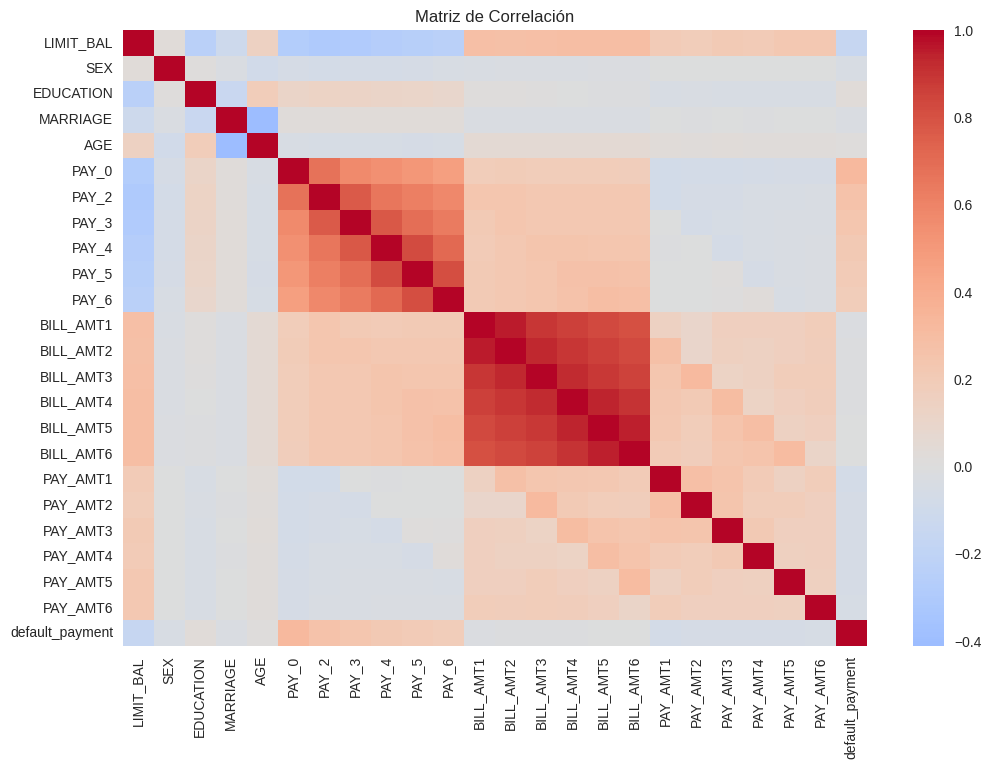

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Matriz de Correlación")
plt.show()

Vemos que la variable objetivo default_payment está algo correlacionada con PAY_0 (último estado de pago), lo que confirma que el historial de pagos recientes es buen predictor.

# **MODELADO**

1. División de datos:

In [15]:
X = df.drop(columns=['default_payment'])
y = df['default_payment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

2. Vamos a estandarizar las variables numéricas para los modelos lineales.

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Logistic Regression**

In [17]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_log = logreg.predict(X_test_scaled)
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:,1]))

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.69      0.24      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000

ROC-AUC: 0.715023533995432


El modelo de regresión logística acierta bien los clientes que pagan, pero tiene bajo recall en impagos (24%). Es un buen modelo base, interpretable y rápido.

# **Random Forest**

In [18]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7009
           1       0.65      0.37      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000

ROC-AUC: 0.758976637556979


El modelo random forest mejora ligeramente respecto a la regresión logística. Detecta más impagos (recall 37%), aunque sigue costándole identificar bien la clase minoritaria.

# **XGBoost**

In [19]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("\n=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1]))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:32:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.66      0.36      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000

ROC-AUC: 0.7698392588305243


Es el mejor modelo en términos globales. Consigue el mayor poder de discriminación entre pagadores e impagadores, aunque el recall de impagos sigue siendo bajo (36%).

CONCLUSIÓN: Los tres modelos funcionan bien para identificar clientes que pagan, pero fallan en detectar impagos debido al desbalance de clases.
XGBoost ofrece el mejor equilibrio con un ROC-AUC de 0.77, por lo que se selecciona como modelo final.

# **Matriz de confusión**

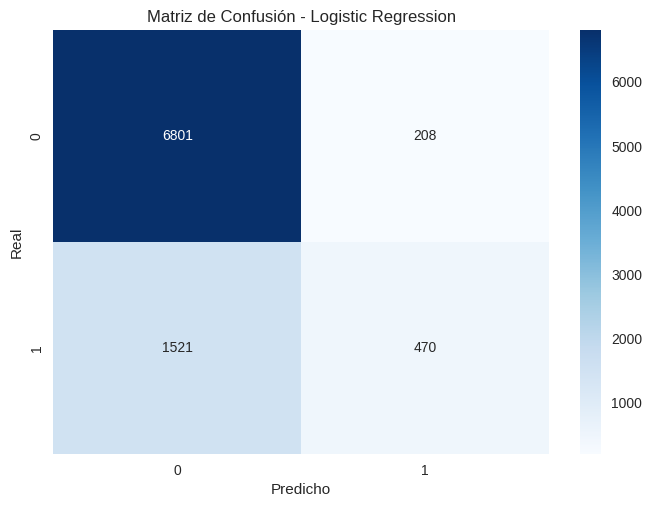

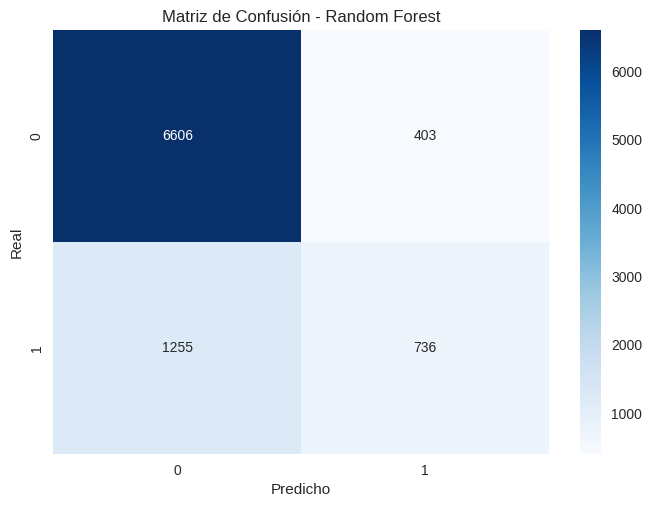

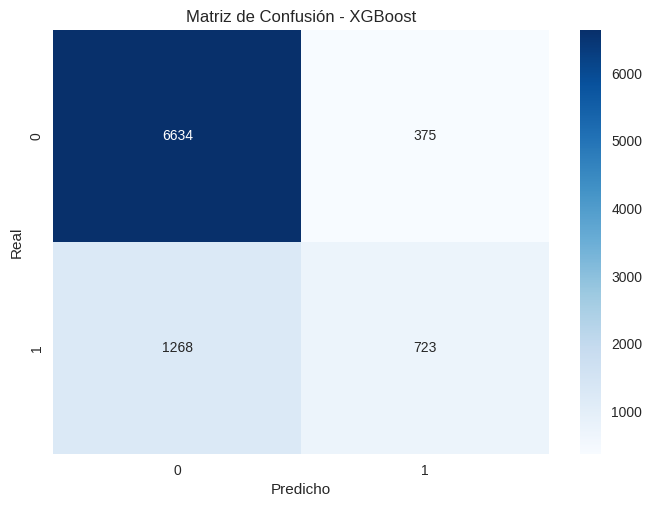

In [20]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("Real")
    plt.xlabel("Predicho")
    plt.show()

plot_confusion(y_test, y_pred_log, "Matriz de Confusión - Logistic Regression")
plot_confusion(y_test, y_pred_rf, "Matriz de Confusión - Random Forest")
plot_confusion(y_test, y_pred_xgb, "Matriz de Confusión - XGBoost")

La Regresión Logística muestra un buen desempeño identificando a los clientes que no impagan (muchos verdaderos negativos), pero tiene dificultades para detectar correctamente a los que sí incumplen, lo que se refleja en un alto número de falsos negativos y un recall bajo. Por su parte, tanto el Random Forest como XGBoost logran un mejor equilibrio: aunque siguen clasificando correctamente a la mayoría de los no impagos, aumentan la capacidad de identificar clientes morosos (mayor número de verdaderos positivos), reduciendo los falsos negativos en comparación con la regresión logística. Entre ellos, XGBoost ofrece el mejor rendimiento global, mostrando un buen compromiso entre precisión general y detección de impagos, lo que lo convierte en el modelo más adecuado para este problema.

# **CURVA DE ROC COMPARATIVA**

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:32:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


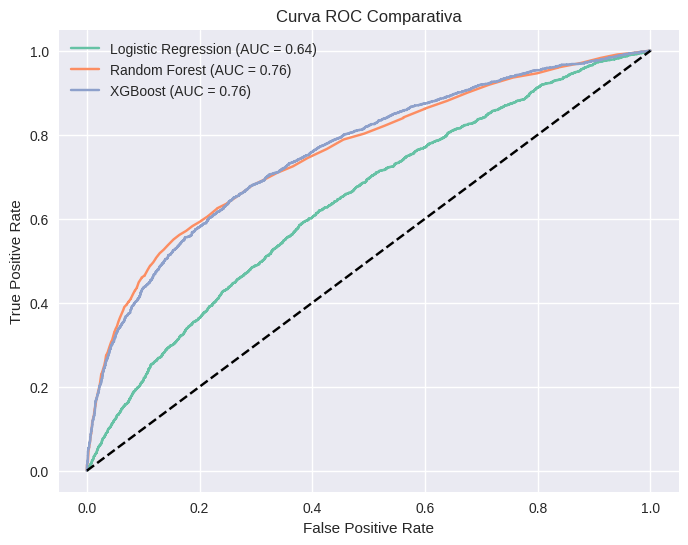

In [21]:
from sklearn.metrics import roc_curve, auc

models = {
    "Logistic Regression": LogisticRegression().fit(X_train, y_train),
    "Random Forest": RandomForestClassifier().fit(X_train, y_train),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss").fit(X_train, y_train)
}

plt.figure(figsize=(8,6))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC Comparativa")
plt.legend()
plt.show()

Nos quedamos con el modelo XGBoost ya que ha sido el que mejor rendimiento ha tenido a lo largo del análisis.

A continuación vamos a guardar el modelo para poder usarlo en predicciones futuras.

In [22]:
import joblib

# Guardarmos
joblib.dump(model, "xgboost_model.pkl")

# Para cargarlo después
model = joblib.load("xgboost_model.pkl")

Vamos a visualizar qué factores afectan más a las predicciones:

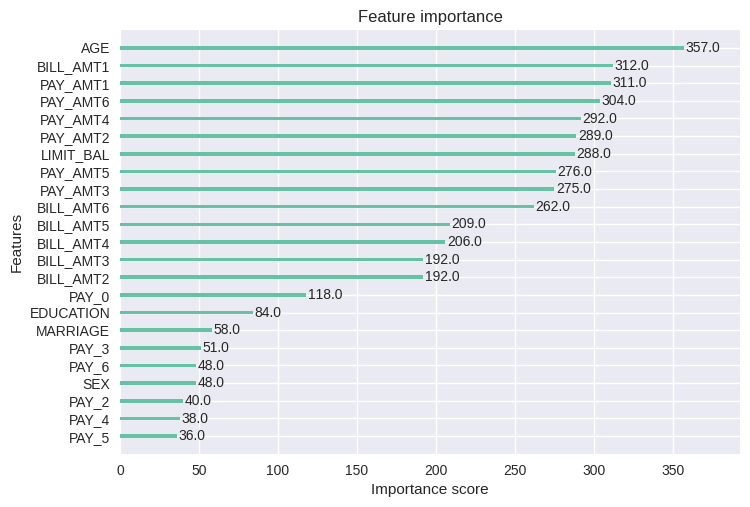

In [23]:
from xgboost import plot_importance

plot_importance(model)
plt.show()